<a href="https://colab.research.google.com/github/sdobnik/aics/blob/master/tutorials/vqa/simple-vqa-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial/handson session is designed based on the Visual Turing Test tutorial in here:
https://github.com/mateuszmalinowski/visual_turing_test-tutorial
Visual Turing Challenge
Mateusz Malinowski and Mario Fritz
Max-Plank Institute

Mehdi Ghanimifard

# Tutorial on Simple Visual Question Answering 

### Understanding the challenge

![](https://github.com/mateuszmalinowski/visual_turing_test-tutorial/raw/master/fig/challenges.jpg)

### Download DAQUAR dataset

In [1]:
! mkdir -p data/daquar
! wget -P data/daquar/ https://raw.githubusercontent.com/mateuszmalinowski/visual_turing_test-tutorial/master/data/daquar/qa.894.raw.test.format_triple
! wget -P data/daquar/ https://raw.githubusercontent.com/mateuszmalinowski/visual_turing_test-tutorial/master/data/daquar/qa.894.raw.train.format_triple
! wget -P data/daquar/ http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
! tar -xvf data/daquar/nyu_depth_images.tar -C data/daquar/
! mv data/daquar/nyu_depth_images data/daquar/images 

--2022-12-15 14:32:07--  https://raw.githubusercontent.com/mateuszmalinowski/visual_turing_test-tutorial/master/data/daquar/qa.894.raw.test.format_triple
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311863 (305K) [text/plain]
Saving to: ‘data/daquar/qa.894.raw.test.format_triple.2’

qa.894.raw.test.for 100%[===================>] 304.55K  --.-KB/s    in 0.04s   

2022-12-15 14:32:08 (8.44 MB/s) - ‘data/daquar/qa.894.raw.test.format_triple.2’ saved [311863/311863]

--2022-12-15 14:32:08--  https://raw.githubusercontent.com/mateuszmalinowski/visual_turing_test-tutorial/master/data/daquar/qa.894.raw.train.format_triple
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.gi

### Understand the data

We can read parts of the training file to see how questions and answers are prepared in the corpus:

In [3]:
! head data/daquar/qa.894.raw.train.format_triple 

what is on the right side of the black telephone and on the left side of the red chair ?
desk
image3
what is in front of the white door on the left side of the desk ?
telephone
image3
what is on the desk ?
book, scissor, papers, tape_dispenser
image3
what is the largest brown objects ?


In [4]:
! ls /home/xilini/aics/tutorials/04-visual-question-answering/data/daquar/images/image1.png

/home/xilini/aics/tutorials/04-visual-question-answering/data/daquar/images/image1.png


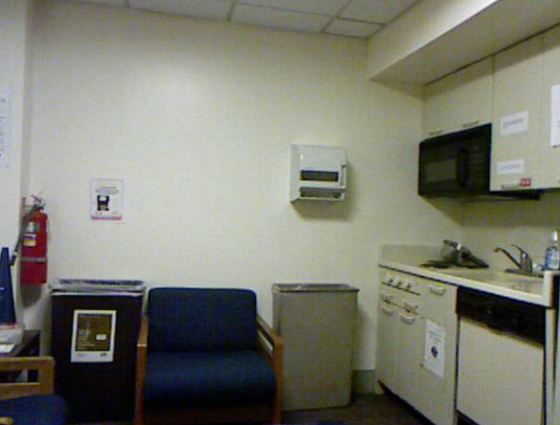

In [5]:
from IPython.display import Image
Image(filename='/home/xilini/aics/tutorials/04-visual-question-answering/data/daquar/images/image1.png') 

## Pre-trained visual features

The idea is that invariant visual features for classification task represents images for other tasks. A pre-trained CNN for ImangeNet task can be used: 

![](https://raw.githubusercontent.com/mateuszmalinowski/visual_turing_test-tutorial/master/fig/features_extractor.jpg)


In order to produce visual features for a given image, we take the output of a layer in convolutional neural networks (CNN) before the final classificatino layer. 

In [6]:
from tensorflow import keras

In [7]:
keras.__version__

'2.8.0'

In [8]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage

In [4]:
#%matplotlib inline
#from matplotlib import pyplot as plt

In [9]:
# If you are running this for the first time in this machine, keras will download the pre-trained weights.
pretrained_cnn_model = ResNet50(weights='imagenet', include_top=False)

2022-12-15 14:34:57.357995: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 14:34:57.360824: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
pretrained_cnn_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Notice that the output must be in shape `[batch_size, width, height, features]` but since the last layer is the result of a global spatial average pooling the `width` and `hight` will be equal to 1: 

In [11]:
pretrained_cnn_model.output.shape

TensorShape([None, None, None, 2048])

For example, the image `image3.png` can be processed with this model:

In [12]:
from PIL import Image

In [13]:
# first we read the image from file and resize it to the ImageNet size
image3 = kimage.load_img("/home/xilini/aics/tutorials/04-visual-question-answering/data/daquar/images/image1.png", target_size=[224,224])

# we have to convert it to numpy array:
image3_array = kimage.img_to_array(image3)

# the neural network is designed to process a batch of images as input.
# so, need to make it as an array of images:
images_array = np.array([
    image3_array,
])

# At this point we suppose that image is prepared as an RGB formated array
# with integer values of 0-255 for each color code.
# we should make sure that the format is matching input format of the pre-trained network.
# (in this case, the following code makes convernt RGB to BGR)
images_ready = preprocess_input(images_array)

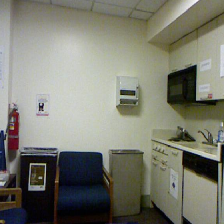

In [11]:
image3

Now, we can the pre-processed image use the CNN model to produce visual features:

In [14]:
vfearues = pretrained_cnn_model.predict(images_ready)
print('the output shape:', vfearues.shape)
image3_features = vfearues[0].flatten()

print('     dtype:', image3_features.dtype)
print(' dimension:', image3_features.shape[0])
print('the vector:', image3_features)


the output shape: (1, 7, 7, 2048)
     dtype: float32
 dimension: 100352
the vector: [0.       0.       0.       ... 7.895452 0.       0.      ]


In [15]:
# we can make this into a function (from file path to feature vectors)
# this is function doesn't have an ideal performance but it would be useful for the sake of this tutorial
def img2vec(image_path):
    x = kimage.load_img(image_path, target_size=[224,224])
    x_array = kimage.img_to_array(x)
    xs_array = np.array([x_array,])
    # notice that we are not using full capacity of the GPU when we are passing only one image per prediction.
    # we could have a larger batch.
    return pretrained_cnn_model.predict(preprocess_input(xs_array)).flatten()


## A Vision and Language Network

### Understand this neural network model

In this tutorial, we want to build a neural net function, with inputs being a question and its context picture and the output being a single word answer:

![](https://github.com/mateuszmalinowski/visual_turing_test-tutorial/raw/master/fig/LSTM_vision_model.jpg)

### Preprocess and prepare the data

The goal is to first prepare the text for processing. Also apply techniques for dealing with out-of-vocabulary (OOV) words, e.g. adding `<unk>` for rare words and `<num>` for numbers. 

*** (1) Build the vocabulary, (2) Remove punctuation, and (3) mask numbers from text if it's needed***

In [14]:
# You can skip this part and use the prepared files in next step

In [16]:
import string
from collections import Counter, defaultdict 

def preprocess_triple_file(filepath):
    # useful metadata:
    # vocabulary, longest_sentence_length
    
    # vocabulary for each file
    metadata = {
        'questions': {'vocab': Counter(), 'max_len': 0},
        'answers': {'vocab': Counter(), 'max_len': 0},
        'contexts': {'vocab': Counter(), 'max_len': 0},
    }
    
    
    # split the file into three parallel text files:
    files = {
        'questions': open(filepath+'.questions', 'w'),
        'answers'  : open(filepath+'.answers', 'w'),
        'contexts' : open(filepath+'.contexts', 'w'),
    }
    
    def process(s, mask_numbers=True, metadata=None):
        word_sequence = [w.strip().rstrip(string.punctuation) for w in s.split()]
        
        ### Mask numbers here ###
        #def is_number(s):
        #    try:
        #        float(s)
        #        return True
        #    except ValueError:
        #        return False
        #
        #if mask_numbers:
        #    word_sequence = ['<num>' if mask_numbers and is_number(w) else w for w in word_sequence]

        metadata['vocab'].update(word_sequence)
        metadata['max_len'] = max(len(word_sequence), metadata['max_len'])

        return ' '.join(word_sequence)
    
    
    # stateful reading of the file, each line changes the states as follwing:
    # question => answer => context => question
    state = 'questions'
    for line in open(filepath, encoding='utf-8'):
        files[state].write(process(line, metadata=metadata[state])+'\n')
        
        if state == 'questions':
            state = 'answers'
        elif state == 'answers':
            state = 'contexts'
        elif state == 'contexts':
            state = 'questions'
        
    for state in files:
        files[state].close()

    np.save(filepath+'.metadata.npy', metadata)
    return None

# process these files and produce new files:
# training qa data "data/daquar/qa.894.raw.train.format_triple"
# testing qa data "data/daquar/qa.894.raw.test.format_triple"

preprocess_triple_file("data/daquar/qa.894.raw.train.format_triple")
preprocess_triple_file("data/daquar/qa.894.raw.test.format_triple")

In [17]:
! ls data/daquar/qa.894.raw.train.format_triple.*
! ls data/daquar/qa.894.raw.test.format_triple.*

data/daquar/qa.894.raw.train.format_triple.1
data/daquar/qa.894.raw.train.format_triple.2
data/daquar/qa.894.raw.train.format_triple.answers
data/daquar/qa.894.raw.train.format_triple.contexts
data/daquar/qa.894.raw.train.format_triple.metadata.npy
data/daquar/qa.894.raw.train.format_triple.questions
data/daquar/qa.894.raw.test.format_triple.1
data/daquar/qa.894.raw.test.format_triple.2
data/daquar/qa.894.raw.test.format_triple.answers
data/daquar/qa.894.raw.test.format_triple.contexts
data/daquar/qa.894.raw.test.format_triple.metadata.npy
data/daquar/qa.894.raw.test.format_triple.questions


In [18]:
!  head data/daquar/qa.894.raw.train.format_triple.questions

what is on the right side of the black telephone and on the left side of the red chair 
what is in front of the white door on the left side of the desk 
what is on the desk 
what is the largest brown objects 
what color is the chair in front of the white wall 
what is on the right side of the notebook on the desk 
what is on the right and left and in front of the papers on the desk 
what is on the desk and behind the black cup 
how many bottles are on the desk 
what is in front of the papers and notebook and bottles 


In [18]:
# Now, we can read from preprocessed files but still there are some preprocessing left to do

In [19]:
metadata = np.load('data/daquar/qa.894.raw.train.format_triple.metadata.npy', allow_pickle=True)[None][0]
question_len = metadata['questions']['max_len']
vocab = metadata['questions']['vocab']
# dump the frequencies:
vocab = ['<pad>', '<unk>', '?']+[w for w,f in vocab.items()]# if f > 1] # don't keep the rare words.
word2index = defaultdict(lambda: 1, zip(vocab, range(len(vocab)))) # this will set <unk> for unknwon words
#{w: wid for wid, w in enumerate(vocab)}
answers = metadata['answers']['vocab']
answers = ['<unk>']+[w for w,f in answers.items()]# if f > 1] # don't keep the rare answers.
answer2index = defaultdict(lambda: 0, zip(answers, range(len(answers)))) # this will set <unk> for unknwon words
#{w: wid for wid, w in enumerate(answers)}

In order to deal with large files in python we need to write generators. But for this tutorial we are not working with very large dataset. So, we can pus all training data lists:

In [20]:
X_questions = [
    [word2index['<pad>']]*(question_len-len(line.split()))+[word2index[w.strip()] for w in line.split()]+[word2index['?']]
    for line in open('data/daquar/qa.894.raw.train.format_triple.questions')
]

Y_answers = [
    [answer2index[w.strip()] for w in line.split()]
    for line in open('data/daquar/qa.894.raw.train.format_triple.answers')
]

In [21]:
len(X_questions)

6795

In [22]:
import tqdm

# this code takes time:
X_images = [
    img2vec("data/daquar/images/{0}.png".format(image_name.strip()))
    for n, image_name in tqdm.tqdm(enumerate(open('data/daquar/qa.894.raw.train.format_triple.contexts')))
    if n < 100
]

6795it [00:31, 215.51it/s]


In [23]:
X_images[0].shape

(100352,)

In [24]:
len(X_images)

100

In [26]:
X_images[0].shape

(100352,)

In [27]:
7 * 7 * 2048

100352

In [28]:
# repeat questions with several answers, and flatten them with one answer:
trainig_data = list(zip(*[(q,i,a) for q, i, a_s in zip(X_questions,X_images,Y_answers) for a in a_s]))

In [29]:
X_train = [np.array(trainig_data[0]), np.array(trainig_data[1])]
Y_train = np.array(trainig_data[2])
visual_vec_len = 2048 #X_train[1].shape[1]

In [30]:
print('the number of all possible answers:', len(answers))
print('the size of vocabulary:', len(vocab))
print('the total number of training samples', len(Y_train))
print('the total number of images', len(set([image_name for image_name in open('data/daquar/qa.894.raw.train.format_triple.contexts')])))

the number of all possible answers: 500
the size of vocabulary: 879
the total number of training samples 116
the total number of images 794


In [31]:
X_questions_test = [
    [word2index['<pad>']]*(question_len-len(line.split()))+[word2index[w.strip()] for w in line.split()][:question_len]+[word2index['?']]
    for n, line in tqdm.tqdm(enumerate(open('data/daquar/qa.894.raw.test.format_triple.questions')))
    if n < 100
]

Y_answers_test = [
    [answer2index[w.strip()] for w in line.split()]
    for n, line in tqdm.tqdm(enumerate(open('data/daquar/qa.894.raw.test.format_triple.answers')))
    if n < 100
]

# this code takes time:
X_images_test = [
    img2vec("data/daquar/images/{0}.png".format(image_name.strip()))
    for n, image_name in tqdm.tqdm(enumerate(open('data/daquar/qa.894.raw.test.format_triple.contexts')))
    if n < 100
]

test_data = list(zip(*[(q,i,a) for q, i, a_s in zip(X_questions_test,X_images_test,Y_answers_test) for a in a_s]))

X_test = [np.array(test_data[0]), np.array(test_data[1])]
Y_test = np.array(test_data[2])

5673it [00:00, 1618658.95it/s]
5673it [00:00, 2032310.09it/s]
5673it [00:30, 183.81it/s]


In [32]:
X_test[0][0]

array([  0,   0,   0,   0,   0,   0,   0,   3,   4,   5,   6,  13,   8,
         9,   6,  19, 187,   5,   6,  66,  12,   5,   7,   8,   9,   6,
        43, 226,   2])

### A Keras model

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Concatenate, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D, Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [57]:
AveragePooling2D()

In [58]:
vis_vec

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'flatten')>

In [35]:
input_question = Input([question_len+1,])
input_context = Input([7*7*2048,])

# learn embedings (size=50 as we chose just now :D)
q_embs = Embedding(len(vocab), 50)(input_question)

# encode the question
q_encoded = LSTM(50)(q_embs)

mlp_1 = Dense(visual_vec_len, activation='tanh')(q_encoded)

# spatial average
vis_vec = Flatten()(AveragePooling2D([7,7])(Reshape([7,7,2048])(input_context)))

# question + image
q_composed = Concatenate()([vis_vec, mlp_1])

mlp_2 = Dropout(0.2)(Dense(visual_vec_len, activation='relu')(q_composed))

final_a = Dense(len(answers), activation='softmax')(mlp_2)

model = Model([input_question, input_context], final_a)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100352)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 7, 7, 2048)   0           ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 29, 50)       43950       ['input_2[0][0]']                
                                                                                              

## Train the model

In [36]:
# what is the loss, and how the parameters should be updated:
model.compile('adam', 'sparse_categorical_crossentropy')

In [37]:
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(patience=5)])

Epoch 1/100
4/4 [==============================] - 3s 357ms/step - loss: 6.9505 - val_loss: 7.2015
Epoch 2/100
4/4 [==============================] - 0s 121ms/step - loss: 3.8705 - val_loss: 8.3033
Epoch 3/100
4/4 [==============================] - 1s 126ms/step - loss: 3.0724 - val_loss: 10.3101
Epoch 4/100
4/4 [==============================] - 1s 146ms/step - loss: 2.6836 - val_loss: 10.8101
Epoch 5/100
4/4 [==============================] - 1s 144ms/step - loss: 2.3427 - val_loss: 11.3039
Epoch 6/100
4/4 [==============================] - 1s 152ms/step - loss: 2.2928 - val_loss: 11.5733


In [38]:
model.save('saved_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [39]:
for k in X_test[0][1:2]:
    print(k)

[ 0  0  0  0  0  0  0  0  0  0  3  4  5  6 13  8  9  6 60 61 12  5  6  7
  8  9  6 15  2]


In [51]:
print('a test question:', ' '.join([vocab[wid] for sent in X_test[0][3:4] for wid in sent if wid != 0]))
print('the dataset answer:', ' '.join([answers[wid] for wid in Y_test[3:4] ]))
print('the predicted answer:', answers[np.argmax(model.predict([X_test[0][3:4], X_test[1][3:4]]), 1)[0]])
print('image:', [image_name.strip() for image_name in open('data/daquar/qa.894.raw.test.format_triple.contexts')][1])

a test question: how many objects are between the fire extinguisher and the white oven on the floor ?
the dataset answer: 3
the predicted answer: 1
image: image1


In [46]:
answ = answers[np.argmax(model.predict([X_test[0][1:2], X_test[1][1:2]]), 1)[0]]

In [47]:
answ

'1'

In [52]:
np.argmax(model.predict([X_test[0], X_test[1][1:5]]), 1)[0]

24

In [56]:
answers[39]

'purple'

![](https://github.com/sdobnik/aics/blob/master/tutorials/vqa/data/daquar/images/image1.png?raw=1)

In [53]:
results = np.argmax(model.predict(X_test), 1)

In [55]:
results

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 39, 39, 39, 39, 39, 39, 24,
       39, 24, 32, 32, 32, 32, 24, 23, 24, 24, 25, 24, 24, 24, 24, 24, 24,
       24, 39, 24, 39, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       32, 32, 32, 32, 24, 24, 24, 49, 49, 49, 49, 49, 24, 24, 24, 23, 23,
       23, 49, 49, 49, 49, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24,
       24, 24, 32, 32, 32, 23, 24, 24, 49, 49, 49, 49, 49, 49, 49, 49, 23,
       23, 23, 49, 49, 23, 23, 23])

In [54]:
X_test[0][10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 25,  4,  6, 14, 65, 17,
       18,  9,  6, 26,  5,  6, 13,  8,  9,  6, 21,  2])

In [45]:
index2sent = lambda x: ' '.join([vocab[wid] for wid in x if wid != 0])
index2sent(X_test[0][9]), answers[Y_test[9]], answers[results[9]]

('what is under the pan ?', 'oven', '1')

![](https://github.com/sdobnik/aics/blob/master/tutorials/vqa/data/daquar/images/image2.png?raw=1)

In [46]:
! head -120 data/daquar/qa.894.raw.test.format_triple 

what is on the left side of the white oven on the floor and on right side of the blue armchair ?
garbage_bin
image1
what is on the left side of the fire extinguisher and on the right side of the chair ?
table
image1
what is between the the two white and black garbage bins ?
chair
image1
how many objects are between the fire extinguisher and the white oven on the floor ?
3
image1
what is the largest object in this picture ?
washing_machine
image1
how many plastic bottles are between the white fridge and the oven ?
5
image2
what is under the white cabinet on the right side of the oven and and on the left side of the fridge ?
sink
image2
what is on the left side of the white sink and under the cabinet ?
microwave
image2
how many white objects in this picture ?
9
image2
what is under the pan ?
oven
image2
what color is the red object in front of the wall on the left side of the desk ?
paper_tray
image9
what is above the desk in fornt of the scissor ?
hole_puncher
image9
what is the largest

In [47]:
input_question = Input([question_len+1,])
input_context = Input([7*7*visual_vec_len,])

# learn embedings (size=50 as we chose just now :D)
q_embs = Embedding(len(vocab), 50)(input_question)

# encode the question
q_encoded = LSTM(50)(q_embs)

mlp_1 = Dense(visual_vec_len, activation='tanh')(q_encoded)

# spatial average
q_composed = Concatenate()([Flatten()(AveragePooling2D([7,7])(Reshape([7,7,2048])(input_context))), mlp_1])

mlp_2 = Dropout(0.2)(Dense(visual_vec_len, activation='relu')(q_composed))

final_a = Dense(len(answers), activation='softmax')(mlp_2)

model = Model([input_question, input_context], final_a)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100352)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 7, 7, 2048)   0           ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 29, 50)       43950       ['input_4[0][0]']                
                                                                                            

# Discussions

In [ ]:
# the goal is come with discussions about what can be done better than what we have in this model.